In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import eigsh
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import rbf_kernel
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import diags
from scipy.sparse.csgraph import laplacian



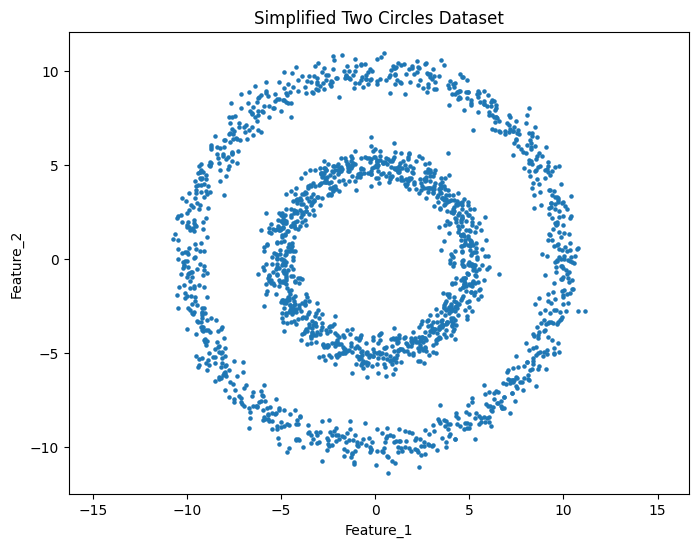

In [2]:

np.random.seed(42)


n_samples = 1000  # samples per circle
noise_std = 0.5  # standard deviation of Gaussian noise

# Generate circular data points for the outer and inner circles
outer_circle_x = np.cos(np.linspace(0, 2 * np.pi, n_samples)) * 10
outer_circle_y = np.sin(np.linspace(0, 2 * np.pi, n_samples)) * 10
inner_circle_x = np.cos(np.linspace(0, 2 * np.pi, n_samples)) * 5
inner_circle_y = np.sin(np.linspace(0, 2 * np.pi, n_samples)) * 5

# Combine both circles into a single dataset for X and Y
circles_data = np.vstack((np.vstack((outer_circle_x, outer_circle_y)).T,
                          np.vstack((inner_circle_x, inner_circle_y)).T))

# Add noise to the data
noise = np.random.normal(scale=noise_std, size=circles_data.shape)
circles_data_noisy = circles_data + noise

# Create a DataFrame for the simplified dataset
circles_df = pd.DataFrame(circles_data_noisy, columns=['Feature_1', 'Feature_2'])

# Plot the simplified dataset
plt.figure(figsize=(8, 6))
plt.scatter(circles_df['Feature_1'], circles_df['Feature_2'], s=5)
plt.title("Simplified Two Circles Dataset")
plt.xlabel("Feature_1")
plt.ylabel("Feature_2")
plt.axis('equal')
plt.show()



In [3]:
def get_affinity(data):
      """
      Construct the affinity matrix using the Gaussian kernel method.

      Parameters:
      - gamma: float, the scale parameter for the Gaussian kernel.
      """
      
      gamma = 5

      # Compute the pairwise squared Euclidean distances between points in the dataset
      sq_dists = squareform(pdist(data, 'sqeuclidean'))

      # Apply the Gaussian kernel to compute affinities
      affinities = np.exp(-gamma * sq_dists)

      # Store the dense affinities matrix directly
      return affinities

In [5]:
affinity_matrix = get_affinity(circles_df)
affinity_matrix

array([[1.00000000e+00, 1.79453590e-02, 4.96135405e-01, ...,
        2.11053427e-86, 1.34008615e-86, 2.06074884e-43],
       [1.79453590e-02, 1.00000000e+00, 1.35490609e-02, ...,
        4.01724936e-90, 7.07984772e-91, 1.22629492e-45],
       [4.96135405e-01, 1.35490609e-02, 1.00000000e+00, ...,
        1.04058337e-76, 6.04425755e-77, 1.36319223e-36],
       ...,
       [2.11053427e-86, 4.01724936e-90, 1.04058337e-76, ...,
        1.00000000e+00, 9.02730211e-01, 2.61251014e-08],
       [1.34008615e-86, 7.07984772e-91, 6.04425755e-77, ...,
        9.02730211e-01, 1.00000000e+00, 1.51914801e-08],
       [2.06074884e-43, 1.22629492e-45, 1.36319223e-36, ...,
        2.61251014e-08, 1.51914801e-08, 1.00000000e+00]])

In [6]:
def get_laplacian(affinity_matrix):
    laplacian_matrix = laplacian(affinity_matrix, normed=False)
    laplacian_matrix = (laplacian_matrix + laplacian_matrix.T) / 2
    return laplacian_matrix

In [7]:
laplacian_matrix = get_laplacian(affinity_matrix)

laplacian_matrix

array([[ 8.45557896e+00, -1.79453590e-02, -4.96135405e-01, ...,
        -2.11053427e-86, -1.34008615e-86, -2.06074884e-43],
       [-1.79453590e-02,  3.63248024e+00, -1.35490609e-02, ...,
        -4.01724936e-90, -7.07984772e-91, -1.22629492e-45],
       [-4.96135405e-01, -1.35490609e-02,  9.08851626e+00, ...,
        -1.04058337e-76, -6.04425755e-77, -1.36319223e-36],
       ...,
       [-2.11053427e-86, -4.01724936e-90, -1.04058337e-76, ...,
         5.03566685e+00, -9.02730211e-01, -2.61251014e-08],
       [-1.34008615e-86, -7.07984772e-91, -6.04425755e-77, ...,
        -9.02730211e-01,  4.42410849e+00, -1.51914801e-08],
       [-2.06074884e-43, -1.22629492e-45, -1.36319223e-36, ...,
        -2.61251014e-08, -1.51914801e-08,  3.77049181e+00]])

In [8]:
import scipy

def optimal_clusters_dynamic(laplacian_matrix):
  if scipy.sparse.issparse(laplacian_matrix):
    # If the Laplacian matrix is sparse, convert it to a dense array
    laplacian_matrix = laplacian_matrix.toarray()
  # Perform eigenvalue decomposition
  laplacian_matrix = laplacian_matrix.astype(np.float64)
  np.fill_diagonal(laplacian_matrix, laplacian_matrix.diagonal() + 1e-5)
  # upper_limit_k = min(self.laplacian_matrix.shape[0]-2, 100)
  eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)

  # Sort the eigenvalues in descending order
  sorted_eigenvalues = np.sort(eigenvalues)[::-1]

  # Calculate the percentage change between consecutive eigenvalues
  delta_eigenvalues = np.diff(sorted_eigenvalues) / sorted_eigenvalues[:-1]
  largest_drop_index = np.argmin(delta_eigenvalues)
  return largest_drop_index + 1

In [10]:
num_of_clusters = optimal_clusters_dynamic(laplacian_matrix)

num_of_clusters

1998

In [11]:
def spectral_embedding(laplacian_matrix):
    # Ensure the Laplacian matrix is in the correct format
    if scipy.sparse.issparse(laplacian_matrix):
        laplacian_matrix = laplacian_matrix.toarray()
    else:
        laplacian_matrix = laplacian_matrix

    # Convert the Laplacian matrix to float64 type and add a small value to its diagonal
    laplacian_matrix = laplacian_matrix.astype(np.float64)
    np.fill_diagonal(laplacian_matrix, laplacian_matrix.diagonal() + 1e-5)

    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)

    # Update the spectral embedding result
    spectral_embedding_result = eigenvectors[:, 1:num_of_clusters + 1]
    return spectral_embedding_result

In [12]:
spectral_embedding_result = spectral_embedding(laplacian_matrix)

In [13]:
spectral_embedding_result

array([[-2.23607317e-02,  4.14624733e-02, -1.29841210e-02, ...,
         3.53860414e-22,  3.29025649e-20,  1.07786418e-19],
       [-2.23607313e-02,  4.09280480e-02, -1.45606121e-02, ...,
         5.94626995e-18, -2.66447017e-17, -2.81881078e-17],
       [-2.23607317e-02,  4.14320274e-02, -1.30677748e-02, ...,
        -1.21903446e-18,  4.23193055e-18,  1.23370002e-17],
       ...,
       [ 2.23606260e-02, -3.91268977e-09,  8.88971869e-09, ...,
        -3.80271378e-19, -5.75146787e-20, -2.33022163e-19],
       [ 2.23606260e-02, -3.92597632e-09,  8.92280758e-09, ...,
         6.52285111e-20, -8.87896322e-20, -2.29470914e-19],
       [ 2.23606260e-02, -3.90398026e-09,  8.86814212e-09, ...,
        -3.75356775e-19, -1.15457937e-19, -5.20279817e-19]])

In [23]:
kmeans = KMeans(n_clusters=len(circles_df) - num_of_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(spectral_embedding_result)

C:\Users\10063\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
circles_df['label'] = cluster_labels

In [25]:
circles_df

,Feature_1,Feature_2,label
0,10.248357,-0.069132,1
1,10.323646,0.824409,1
2,9.882132,0.008718,1
3,10.787826,0.572390,1
4,9.762098,0.522832,1
...,...,...,...
1995,4.153826,-0.361408,0
1996,4.011366,0.281213,0
1997,3.967063,-0.048664,0
1998,3.960995,-0.191596,0


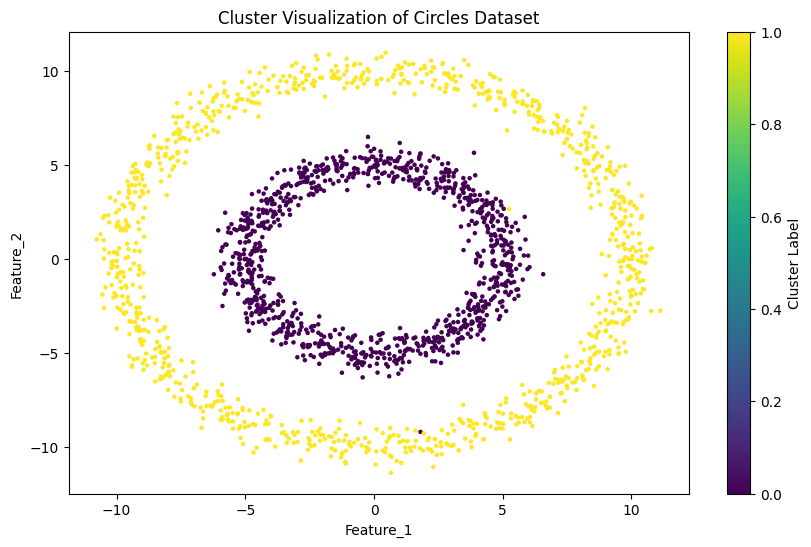

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(circles_df['Feature_1'], circles_df['Feature_2'], c=circles_df['label'], cmap='viridis', s=5)
plt.title('Cluster Visualization of Circles Dataset')
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')
plt.colorbar(label='Cluster Label')
plt.show()



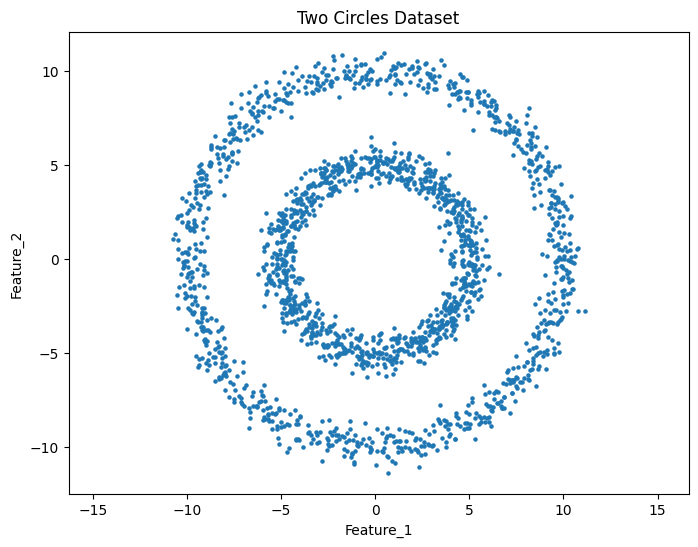

In [29]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_samples = 1000  # samples per circle
noise_std = 0.5  # standard deviation of Gaussian noise

# Generate circular data points for the outer and inner circles
outer_circle_x = np.cos(np.linspace(0, 2 * np.pi, n_samples)) * 10
outer_circle_y = np.sin(np.linspace(0, 2 * np.pi, n_samples)) * 10
inner_circle_x = np.cos(np.linspace(0, 2 * np.pi, n_samples)) * 5
inner_circle_y = np.sin(np.linspace(0, 2 * np.pi, n_samples)) * 5

# Combine both circles into a single dataset for X and Y
circles_data = np.vstack((np.vstack((outer_circle_x, outer_circle_y)).T,
                          np.vstack((inner_circle_x, inner_circle_y)).T))

# Add noise to the data
noise = np.random.normal(scale=noise_std, size=circles_data.shape)
circles_data_noisy = circles_data + noise

# Create a DataFrame for the simplified dataset
circles_df = pd.DataFrame(circles_data_noisy, columns=['Feature_1', 'Feature_2'])

# Plot the simplified dataset
plt.figure(figsize=(8, 6))
plt.scatter(circles_df['Feature_1'], circles_df['Feature_2'], s=5)
plt.title("Two Circles Dataset")
plt.xlabel("Feature_1")
plt.ylabel("Feature_2")
plt.axis('equal')
plt.show()

C:\Users\10063\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


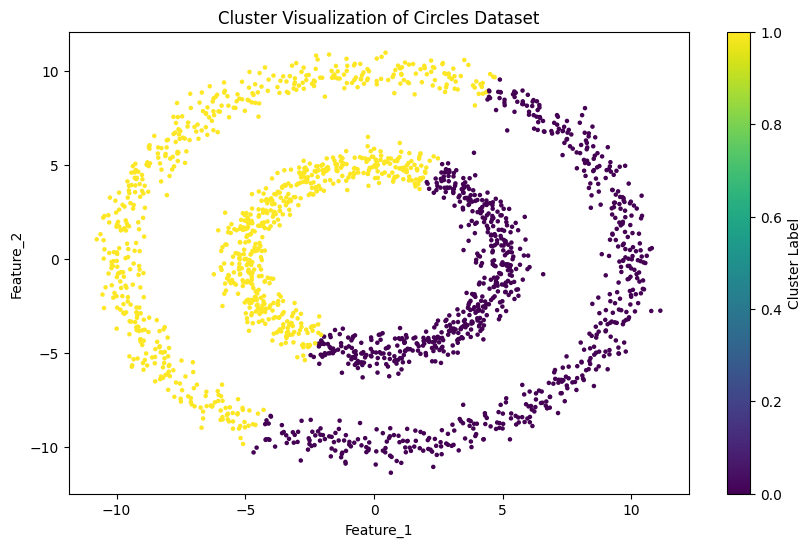

In [30]:
kmeans = KMeans(n_clusters=len(circles_df) - num_of_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(circles_df)

circles_df['label'] = cluster_labels

plt.figure(figsize=(10, 6))
plt.scatter(circles_df['Feature_1'], circles_df['Feature_2'], c=circles_df['label'], cmap='viridis', s=5)
plt.title('Cluster Visualization of Circles Dataset')
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')
plt.colorbar(label='Cluster Label')
plt.show()